In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 
# %matplotlib notebook

import ipysh

%aimport models.base

import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH
%aimport models.AEFIT5
%aimport models.Compose
%aimport models.GAN3

import livelossplot.keras
class PlotLossesCallback(livelossplot.keras.PlotLossesCallback):
    def on_train_batch_begin(self, a, b): pass
    def on_train_batch_end(self, a, b): pass
    def on_test_begin(self, a): pass
    def on_test_end(self, a): pass
    def on_test_batch_begin(self, a, b): pass
    def on_test_batch_end(self, a, b): pass

    
class PlotRelevanceCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(13, 3)
        w = self.model.layers[1].weights
        ax1.bar(range(0,4), w[0][0:4])
        labels = ['Ip','NS','Vt','F']
        plt.sca(ax1)
        plt.xticks(range(0,4), labels, fontsize=10)
        ax2.bar(range(7,17), w[0][4:14])
        plt.sca(ax2)
        plt.xticks(range(7,17), fontsize=10)        
        ax3.bar(range(7,17), w[0][14:24])
        plt.sca(ax3)
        plt.xticks(range(7,17), fontsize=10)       


# ipysh.Bootstrap_support.debug()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Hunch models imported
reload set for module  Hunch_utils
reload set for module  Dummy_g1data
reload set for module  Hunch_lsplot
reload set for module  Hunch_tSNEplot


Using TensorFlow backend.


# TEST QSH


In [2]:
qsh = Dataset_QSH.Dataset_QSH()
import os
file = ipysh.abs_builddir+'/te_db_r15_clean.npy'
try: qsh.load(file)
except: raise FileNotFoundError

qsh.shuffle()
qsh.dim = None
qsh.set_null(np.nan)
qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F'])  ## use this for Br_rm
# qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F','absBr_rm','argBr_rm']) 

# qsh.unbias_mean(0.5, 'te')
# qsh.set_normal_positive(['te'])
# qsh.clip_values(0.1,0.6)
# qsh.set_normal_positive(['te'])

print("QSH rebalanced 15 points size: ", len(qsh))

QSH rebalanced 15 points size:  47567


In [3]:
# Bt_min, Bt_max = np.nanmin(qsh['Bt_rm']), np.nanmax(qsh['Bt_rm'])
Br_min, Br_max = np.nanmin(qsh['Br_rs']), np.nanmax(qsh['Br_rs'])

def _map(xy,p,Br):
    # Bt = (Bt-Bt_min)/(Bt_max-Bt_min)
    Br = (Br-Br_min)/(Br_max-Br_min)
    pBr = tf.concat([p,Br], axis=0)
    # return (xy,pBtBr),(xy,pBtBr)
    return pBr,xy

# ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','absBr_rm~argBr_rm']).map(lambda x,y,br: _map(x,y,br) )
ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','Br_rs']).map(lambda x,y,br: _map(x,y,br) )
[x for x in ds.shuffle(100).batch(1).take(1)][0]

W0904 14:32:19.014590 140235345069888 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:504: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


(<tf.Tensor: id=60, shape=(1, 24), dtype=float32, numpy=
 array([[0.36519378, 0.2528581 , 0.47111174, 0.67255896, 0.03858241,
         0.02481491, 0.02475095, 0.02487895, 0.02477904, 0.02483677,
         0.02496057, 0.02476254, 0.02483356, 0.02492401, 0.02831819,
         0.02476483, 0.02492901, 0.02481538, 0.0259459 , 0.02482827,
         0.0248752 , 0.02482207, 0.02491422, 0.0248263 ]], dtype=float32)>,
 <tf.Tensor: id=61, shape=(1, 30), dtype=float32, numpy=
 array([[0.02677106, 0.09757204, 0.14360444, 0.19783476, 0.26054305,
         0.33116797, 0.4080414 , 0.48839146, 0.5687417 , 0.6456151 ,
         0.7162399 , 0.77894825, 0.83317864, 0.879211  , 0.9178251 ,
         0.14130712, 0.17041862, 0.20598765, 0.21910666, 0.25158447,
         0.26359314, 0.2549018 , 0.25151506, 0.25082302, 0.24350458,
         0.2289837 , 0.21474448, 0.2163004 , 0.208695  , 0.17613998]],
       dtype=float32)>)

In [4]:
vae = models.AEFIT5.AEFIT5(latent_dim=6, feature_dim=30, dprate=0.1, beta=0., scale=2, geometry=[20,20,10,10])
vae.build(input_shape=vae.inference_net.input_shape)
vae.compile( vae.optimizer, tf.losses.mse )

AEFIT5 a ready:


In [ ]:
dds = ds.map(lambda p,xy: (xy,xy))
vae_history = vae.fit( dds.skip(5000).batch(100, drop_remainder=True), validation_data=dds.take(5000).batch(100), epochs=50)

In [5]:
# vae.save('step12_vae_ls')
vae.load('step12_vae_ls')
# plt.figure('vae_history')
# plt.plot(vae_history.history['loss'])
# plt.plot(vae_history.history['val_loss'])

In [6]:
vae1 = models.AEFIT5.AEFIT5(latent_dim=3, feature_dim=24, dprate=0.1, scale=2, geometry=[20,20,10,10])
vae1.generative_net.trainable = False
gen = vae1.inference_net

AEFIT5 a ready:


In [7]:
Dds = ds.map(lambda p,xy: (p, tf.reshape(vae.encode(tf.reshape(xy,[1,-1]),training=False)[0],[-1])) )
[x for x in Dds.batch(1).take(1)][0]

(<tf.Tensor: id=1608, shape=(1, 24), dtype=float32, numpy=
 array([[0.9426364 , 0.5710187 , 0.9012881 , 0.7219089 , 0.02409282,
         0.02565855, 0.02478153, 0.02555126, 0.02526849, 0.02484896,
         0.02530769, 0.02508145, 0.02470935, 0.02505407, 0.02689237,
         0.02612178, 0.02588626, 0.02479223, 0.02523374, 0.02533877,
         0.02488902, 0.02523172, 0.02507981, 0.02488045]], dtype=float32)>,
 <tf.Tensor: id=1609, shape=(1, 6), dtype=float32, numpy=
 array([[-0.10821315, -0.14149037,  0.5209219 ,  0.8505177 ,  0.6526626 ,
         -1.3000746 ]], dtype=float32)>)

In [10]:

# TRAIN MODEL
rel = gen.layers[0]
rel.rate = 0.
# l1_l2 = tf.keras.regularizers.l1_l2
# for l in gen.layers:
#     if issubclass(type(l), tf.keras.layers.Dense):
#         l.activity_regularizer = l1_l2(0.01)

# gen.compile( vae1.optimizer, vae1.loss )
gen.compile( tf.optimizers.Adam(1e-3), tf.losses.mse )

DDS = Dds.prefetch( len(qsh) )


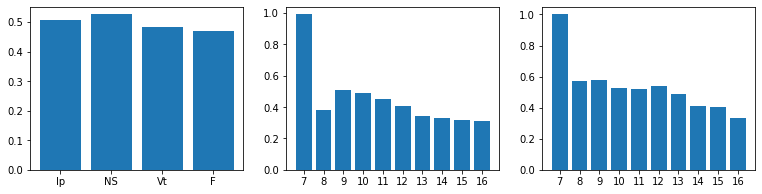

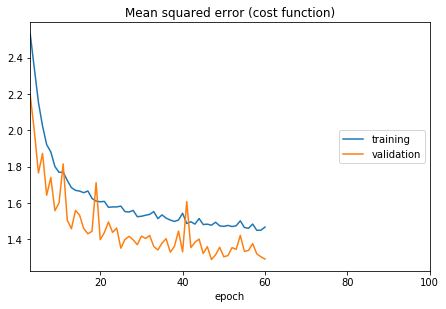

Mean squared error (cost function):
training   (min:    1.449, max:    3.230, cur:    1.467)
validation (min:    1.289, max:    2.734, cur:    1.291)
446/446 [==============================] - 73s 163ms/step - loss: 1.4672 - val_loss: 1.2913
Epoch 61/100
445/446 [============================>.] - ETA: 0s - loss: 1.4705

Exception in thread async train:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/andrea/devel/rfx/rfx-hunch/build/conf/python/site-packages/lib/python3.6/site-packages/nbmultitask.py", line 148, in run
    fn(*self._args,**self._kwargs)
  File "/home/andrea/devel/rfx/rfx-hunch/src/Tprofile_read/models/base.py", line 264, in <lambda>
    super(AsyncTrain, self).__init__(target=lambda thread_print: fn(), name='async train')
  File "<ipython-input-11-d2e48f10d4fd>", line 2, in <lambda>
    callbacks=[PlotLossesCallback(), PlotRelevanceCallback()] )
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 643, in fit
    use_multiprocessing=use_multiprocessing)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_generator.py", line 694, in fit
    steps_name='steps_per_epoch')
  File "/usr/local/lib/python3.6/dist-packages/tensor

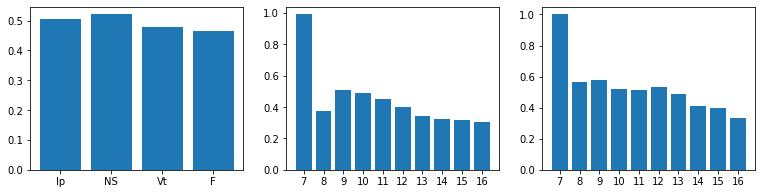

In [11]:
fit = lambda: gen.fit( DDS.skip(3000).batch(100), validation_data=DDS.take(3000).batch(100), epochs=100,
                      callbacks=[PlotLossesCallback(), PlotRelevanceCallback()] )
models.base.fn_thread(gen, fit).control_panel()

In [ ]:
gen.layers[1].weights

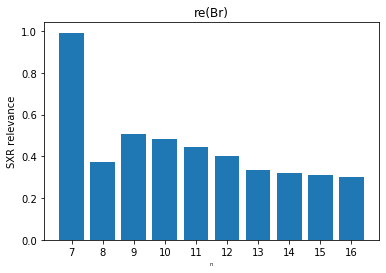

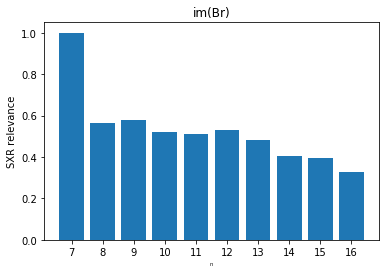

In [420]:
index = qsh[0].n
w = gen.layers[1].weights
%matplotlib inline

def plot_bar_x(index, w, title):
    # this is for plotting purpose
    plt.figure(title)
    plt.bar(index, w)
    plt.xlabel('n', fontsize=5)
    plt.ylabel('SXR relevance', fontsize=10)
    plt.xticks(index, fontsize=10)
    plt.title(title)
    plt.show()

re,im = w[0][4:14], w[0][14:24]
plot_bar_x(index, re, 're(Br)')
plot_bar_x(index, im, 'im(Br)')


In [ ]:
# vae1.save('step12_vae1_p2SXR')
vae1.load('step12_vae1_p2SXR')
# vae.load('step12_gan_PBr_reim')

In [410]:
pos = 0

 80/446 [====>.........................] - ETA: 1:15 - loss: 1.4664

0
 81/446 [====>.........................] - ETA: 1:14 - loss: 1.4626

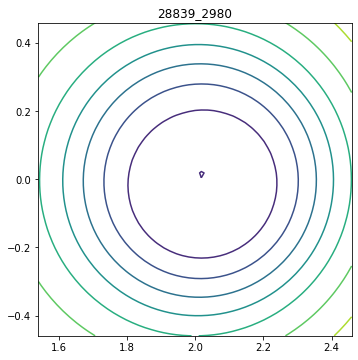

108/446 [======>.......................] - ETA: 1:04 - loss: 1.4900

In [411]:
print(pos)
d_pos = [x for x in ds.skip(pos).batch(1).take(1)][0]
qp = qsh[pos]
qp.plot_countour()


7
221/446 [=============>................] - ETA: 38s - loss: 1.5154

W0904 15:39:55.916660 140235345069888 legend.py:1282] No handles with labels found to put in legend.


222/446 [=============>................] - ETA: 38s - loss: 1.5151

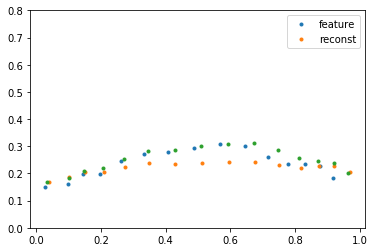

259/446 [================>.............] - ETA: 31s - loss: 1.5118

In [419]:
print(pos)
d_pos = [x for x in ds.skip(pos).batch(1).take(1)][0]

def plot(xy, name=None):
    plt.figure('plot')
    ax = plt.gca()
    ax.legend()
    ax.set_ylim(0.,0.8)
    xy = tf.reshape(xy, [-1])
    x,y = tf.split(xy, num_or_size_splits=2, axis=0)
    plt.plot(x,y,'.', label=name)

xy = d_pos[1]
XY_vae = vae(xy, training=False)
ls = gen(d_pos[0], training=False)
XY = vae.decode(ls, training=False)
# XY = tf.sigmoid(XY)
plot(xy, 'feature')
plot(XY, 'reconst')
plot(XY_vae, 'vae')
pos += 1